# Split dataset and statistics


Split the dataset generated with `generate_dataset.py` and report statistics of splits.

In [2]:
import json

SEED = 42
with open("/plancraft/dataset.json", "r") as f:
    data = json.load(f)

print(len(data))

27180


In [3]:
import random
import sys

sys.path.append("..")

from plancraft.environments.planner import RECIPE_GRAPH

# seed random
random.seed(SEED)

leaves = [node for node in RECIPE_GRAPH.nodes() if RECIPE_GRAPH.out_degree(node) == 0]

# Select leave nodes as holdout targets to ensure that the model has never seen them in plans
train_targets_heldout = random.choices(leaves, k=int(len(leaves) * 0.4))
val_targets_heldout = random.choices(
    train_targets_heldout, k=int(len(train_targets_heldout) * 0.5)
)
train_targets_heldout = set(train_targets_heldout)
val_targets_heldout = set(val_targets_heldout)
print(len(train_targets_heldout), len(val_targets_heldout))

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:9: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils.spawn


119 54


In [4]:
import pandas as pd
import numpy as np

np.random.seed(SEED)
df = pd.DataFrame(data)


def change_keys_of_slotted_inventory(slotted_inventory):
    new_slotted = []
    for item in slotted_inventory:
        item["type"] = item.pop("item")
        item["quantity"] = item.pop("count")
        new_slotted.append(item)
    return new_slotted


df["slotted_inventory"].apply(change_keys_of_slotted_inventory)

print(len(df))

27180


In [5]:
df["hashed_inv"] = df["inventory"].apply(lambda x: tuple(sorted(x.items())))
assert len(df[df.duplicated(subset=["target", "hashed_inv"])]) == 0, "Duplicates found"

In [6]:
df["complexity"] = df["items_used"] * df["optimal_path_length"]
# 5 groups of difficulty
df["complexity_bin"] = pd.qcut(df["complexity"], 5, labels=False, duplicates="drop")
# 1 group of impossible
df["complexity_bin"] = df["complexity_bin"].fillna(5)
print(df["complexity_bin"].value_counts())

df["unseen_in_train"] = df["target"].isin(train_targets_heldout)
df["unseen_in_val"] = df["target"].isin(val_targets_heldout)

NUM_TRAIN_PER_COMPLEXITY = 200
NUM_VAL_PER_COMPLEXITY = 100
NUM_TEST_PER_COMPLEXITY = 100

train_idxs = set()
val_idxs = set()
test_idxs = set()
for group in df.groupby("complexity_bin"):
    new_train_idxs = (
        group[1]
        .loc[~group[1].target.isin(train_targets_heldout)]
        .sample(NUM_TRAIN_PER_COMPLEXITY, random_state=SEED)
        .index
    )
    new_val_idxs = (
        group[1]
        .loc[
            ~group[1].target.isin(val_targets_heldout)
            & ~group[1].index.isin(new_train_idxs)
        ]
        .sample(NUM_VAL_PER_COMPLEXITY, random_state=SEED)
        .index
    )
    new_test_idxs = (
        group[1]
        .loc[~group[1].index.isin(new_train_idxs) & ~group[1].index.isin(new_val_idxs)]
        .sample(NUM_TEST_PER_COMPLEXITY, random_state=SEED)
        .index
    )
    train_idxs.update(new_train_idxs)
    val_idxs.update(new_val_idxs)
    test_idxs.update(new_test_idxs)

df.loc[list(train_idxs), "split"] = "train"
df.loc[list(val_idxs), "split"] = "val"
df.loc[list(test_idxs), "split"] = "test"


print(df["split"].value_counts())
test_df = df[df["split"] == "test"]
train_df = df[df["split"] == "train"]
val_df = df[df["split"] == "val"]

complexity_bin
5.0    9060
0.0    4258
1.0    4093
4.0    3598
3.0    3463
2.0    2708
Name: count, dtype: int64
split
train    1200
test      600
val       600
Name: count, dtype: int64


In [7]:
# assert no duplicates
assert (
    len(train_df[train_df.duplicated(subset=["target", "hashed_inv"])]) == 0
), "Duplicates found"
assert (
    len(val_df[val_df.duplicated(subset=["target", "hashed_inv"])]) == 0
), "Duplicates found"
assert (
    len(test_df[test_df.duplicated(subset=["target", "hashed_inv"])]) == 0
), "Duplicates found"

In [13]:
train_df.reset_index(drop=True, inplace=True)
train_df.drop(columns=["hashed_inv"], inplace=True)
train_df["id"] = train_df.index.map(lambda x: f"TRAIN{x:04d}")


val_df.reset_index(drop=True, inplace=True)
val_df.drop(columns=["hashed_inv"], inplace=True)
val_df["id"] = val_df.index.map(lambda x: f"VAL{x:04d}")

test_df.reset_index(drop=True, inplace=True)
test_df.drop(columns=["hashed_inv"], inplace=True)
test_df["id"] = test_df.index.map(lambda x: f"TEST{x:04d}")

/tmp/ipykernel_81831/35986321.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(columns=["hashed_inv"], inplace=True)
/tmp/ipykernel_81831/35986321.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["id"] = train_df.index.map(lambda x: f"TRAIN{x:04d}")
/tmp/ipykernel_81831/35986321.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df.drop(columns=[

In [14]:
# save the splits
train_df.to_json("/plancraft/data/train.json", orient="records")
val_df.to_json("/plancraft/data/val.json", orient="records")
test_df.to_json("/plancraft/data/test.json", orient="records")

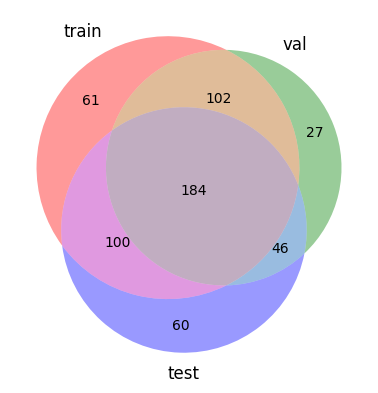

In [15]:
from matplotlib_venn import venn3

venn3(
    [set(train_df.target), set(val_df.target), set(test_df.target)],
    set_labels=["train", "val", "test"],
)

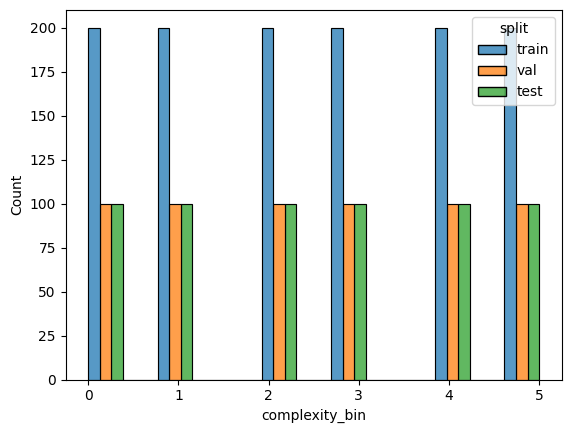

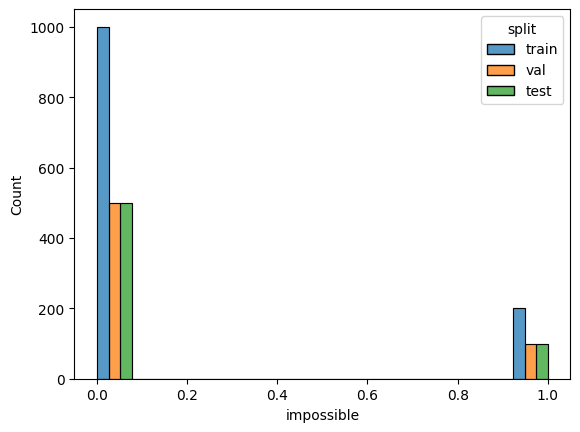

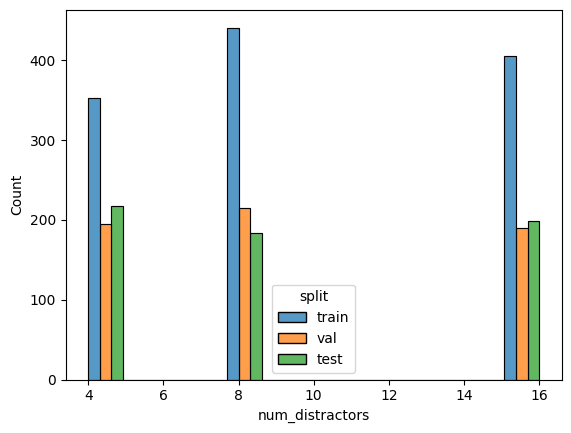

In [16]:
# df["items_used"] = df["items"].apply(len)

import seaborn as sns
import matplotlib.pyplot as plt

all_df = pd.concat([train_df, val_df, test_df])

sns.histplot(x="complexity_bin", data=all_df, hue="split", multiple="dodge")
plt.show()
sns.histplot(x="impossible", data=all_df, hue="split", multiple="dodge")
plt.show()
sns.histplot(x="num_distractors", data=all_df, hue="split", multiple="dodge")
plt.show()

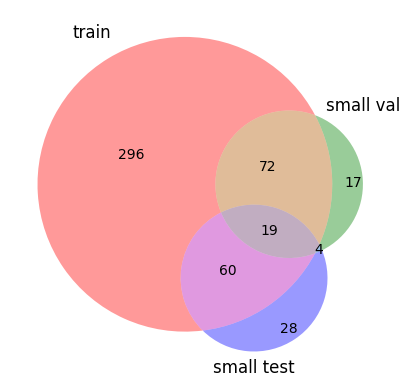

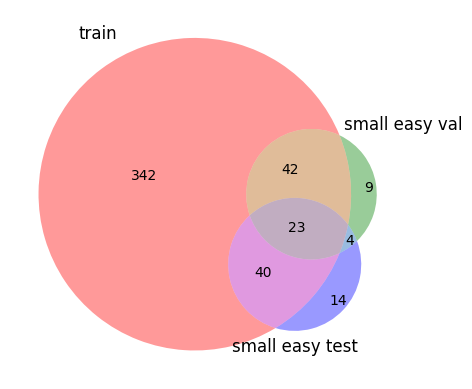

In [44]:
small_val_df = val_df.groupby("complexity_bin").sample(20, random_state=SEED)
small_test_df = test_df.groupby("complexity_bin").sample(20, random_state=SEED)

from matplotlib_venn import venn3
import matplotlib.pyplot as plt

venn3(
    [set(train_df.target), set(small_val_df.target), set(small_test_df.target)],
    set_labels=["train", "small val", "small test"],
)
plt.show()

small_val_df.to_json("/plancraft/data/val.small.json", orient="records")
small_test_df.to_json("/plancraft/data/test.small.json", orient="records")

# easy
small_easy_val_df = val_df[val_df["complexity_bin"] == 0].copy()
small_easy_test_df = test_df[test_df["complexity_bin"] == 0].copy()
venn3(
    [
        set(train_df.target),
        set(small_easy_val_df.target),
        set(small_easy_test_df.target),
    ],
    set_labels=["train", "small easy val", "small easy test"],
)
plt.show()

small_easy_val_df.to_json("/plancraft/data/val.small.easy.json", orient="records")
small_easy_test_df.to_json("/plancraft/data/test.small.easy.json", orient="records")

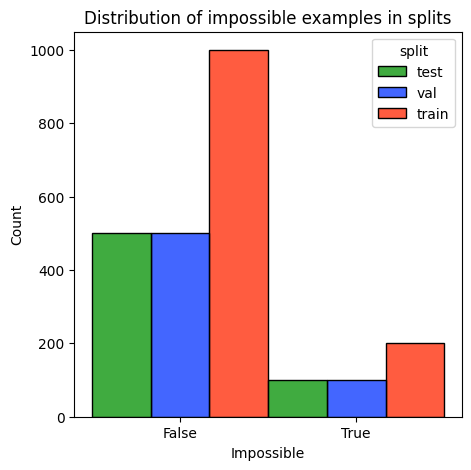

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# sns.histplot(x="complexity_bin", data=df, hue="split", multiple="dodge")

fig = plt.figure(figsize=(5, 5))
df["impossible"] = df["impossible"].astype(str)

colors = ["#008F00", "#0433FF", "#FF2600"]

custom_palette = sns.color_palette(colors)

sns.histplot(
    x="impossible", data=df, hue="split", multiple="dodge", palette=custom_palette
)
plt.xlabel("Impossible")
plt.title("Distribution of impossible examples in splits")
plt.savefig("impossible_split.png", dpi=300)
plt.show()

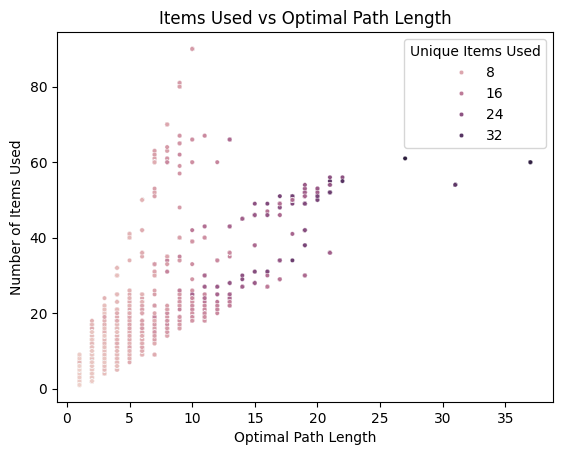

In [31]:
sns.scatterplot(
    x="optimal_path_length",
    y="items_used",
    data=df[df.impossible == "False"],
    hue="unique_items_used",
    alpha=1,
    s=10,
)
plt.xlabel("Optimal Path Length")
plt.ylabel("Number of Items Used")
plt.title("Items Used vs Optimal Path Length")
plt.legend(title="Unique Items Used")
# labels
plt.savefig("items_used_vs_optimal_path_length.png", dpi=300)

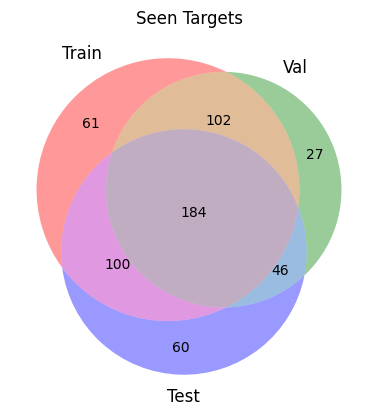

In [29]:
from matplotlib_venn import venn3

venn3(
    [set(train_df.target), set(val_df.target), set(test_df.target)],
    set_labels=["Train", "Val", "Test"],
)
plt.title("Seen Targets")
plt.savefig("seen_targets.png", dpi=300)

Text(0.5, 1.0, 'Complexity Bins')

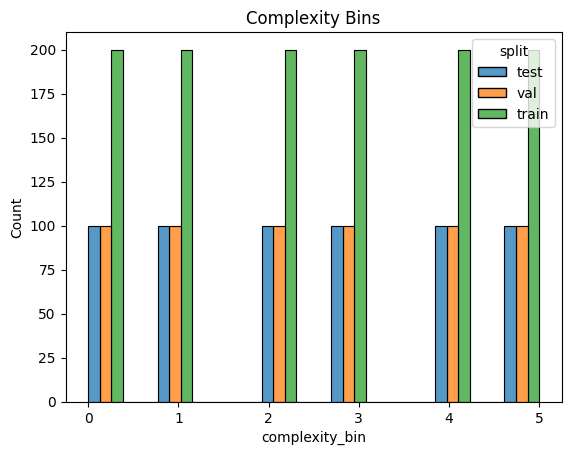

In [33]:
sns.histplot(x="complexity_bin", data=df, hue="split", multiple="dodge")
plt.title("Complexity Bins")
# plt.legend(title="Split")